<a href="https://colab.research.google.com/github/AnaliaLeyez/AnaliaLeyez/blob/main/U6_Prophet_con_ejemplos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prophet:**
Herramienta para la predicción de series de tiempo, desarrollada por el equipo de Facebook (Meta). Permite pronosticar datos de series temporales basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de los días festivos. Funciona mejor con series temporales con fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es robusto ante datos faltantes y cambios de tendencia, y suele gestionar adecuadamente los valores atípicos.

Es un software de código abierto publicado por el equipo de Ciencia de Datos Central de Facebook


Para saber más: https://facebook.github.io/prophet/

¿Por qué necesitamos modelos de Series de Tiempo?
Muchas cosas que nos interesan cambian con el tiempo (precios de acciones, clima, ventas). Pronosticar es anticipar esos cambios.
Para ello debemos tener en cuenta los siguintes términos:

* Tendencia: Crecimiento o decrecimiento general a largo plazo.
* Estacionalidad: Patrones que se repiten en periodos fijos (diaria, semanal, anual).
* Eventos especiales (feriados, promociones): Cambios bruscos que no son tendencia ni estacionalidad.
* Valores atípicos: Picos o valores inusuales.

# Preparamos el entorno

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import yfinance as yf # Para obtener datos financieros
import warnings #módulo para controlar cómo se tratan las advertencias
warnings.filterwarnings('ignore') # Para ignorar warnings de Prophet si aparecen

# Configuración básica de Matplotlib para una mejor visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

**Prophet no entrena directamente en Python**

1-Instala Prophet y cmdstanpy (librerías de Python).

2-Descarga e instala CmdStan (el motor externo en C++).

3-Verifica que todo esté correctamente conectado.

Una vez hecho, Prophet ya puede funcionar.

In [ ]:
# --- SETUP EN COLAB ---
!pip -q install -U prophet cmdstanpy

import sys, cmdstanpy
print("Python:", sys.version)
try:
    print("CmdStan path:", cmdstanpy.cmdstan_path())
except Exception:
    print("Instalando CmdStan (tarda la primera vez)...")
    cmdstanpy.install_cmdstan()  # <- sin 'quiet'
    print("Listo. CmdStan path:", cmdstanpy.cmdstan_path())

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
CmdStan path: /root/.cmdstan/cmdstan-2.37.0


#Estructura del DataFrame para Prophet:

Prophet necesita un DataFrame con exactamente dos columnas con nombres específicos:
* ds: Columna de fecha y/o hora (Timestamp o datetime).
* y: Columna del valor numérico que queremos pronosticar.

#Ejemplo 1:
Pronóstico del S&P 500 (Tendencia y Estacionalidad Anual/Semanal)
Usaremos yfinance para descargar los datos históricos.

In [ ]:
# Descargar datos del S&P 500 (SPY es un ETF que lo sigue de cerca)
data = yf.download('^GSPC', start='2015-01-01', end='2025-11-04') # Usamos ^GSPC para el índice S&P 500
# Inspeccionar los datos
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2726 entries, 2015-01-02 to 2025-11-03
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2726 non-null   float64
 1   (High, ^GSPC)    2726 non-null   float64
 2   (Low, ^GSPC)     2726 non-null   float64
 3   (Open, ^GSPC)    2726 non-null   float64
 4   (Volume, ^GSPC)  2726 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 127.8 KB


Preparar el DataFrame para Prophet:

Renombrar las columnas Date a ds y Close (precio de cierre) a y.
Asegurarse de que ds sea tipo datetime.

In [ ]:
#convierte el índice del DF (en este caso, la columna Date) en una columna regular
df_sp500 = data.reset_index()[['Date', 'Close']] #selecciona solo las columnas
df_sp500.columns = ['ds', 'y'] # renombra las columnas
#convierte una columna a un formato de fecha y hora (datetime)
df_sp500['ds'] = pd.to_datetime(df_sp500['ds']) # Aseguramos formato datetime
print("\nDataFrame para Prophet (S&P 500):")
df_sp500.head()


DataFrame para Prophet (S&P 500):


,ds,y
0,2015-01-02,2058.199951
1,2015-01-05,2020.579956
2,2015-01-06,2002.609985
3,2015-01-07,2025.900024
4,2015-01-08,2062.139893


In [ ]:
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2726 non-null   datetime64[ns]
 1   y       2726 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.7 KB


Inicializar y Entrenar el Modelo Prophet:

Crear una instancia de Prophet y Podemos añadir estacionalidades.
El S&P 500 probablemente tenga estacionalidad anual y semanal (días de la semana).

In [ ]:
# daily_seasonality=False: para desactivar la estacionalidad diaria
# weekly_seasonality=True: para patrones semanales (ej: el precio puede variar según el día de la semana)
# yearly_seasonality=True: para patrones anuales
model_sp500 = Prophet(daily_seasonality=False,
                      weekly_seasonality=True,
                      yearly_seasonality=True,
                     )

# Entrenar el modelo con los datos preparados
model_sp500.fit(df_sp500)
print("\nModelo Prophet para S&P 500 entrenado.")


Modelo Prophet para S&P 500 entrenado.


Crear el DataFrame de Futuro:

Definir cuántos periodos queremos pronosticar.
Usar make_future_dataframe.

In [ ]:
# Crear un DataFrame con las fechas futuras para el pronóstico
future_sp500 = model_sp500.make_future_dataframe(periods=365, #Pronosticar un año hacia adelante
                                                 freq='D') #Frecuencia diaria
print("\nFechas futuras para pronóstico (S&P 500):")
future_sp500.tail()


Fechas futuras para pronóstico (S&P 500):


,ds
3086,2026-10-30
3087,2026-10-31
3088,2026-11-01
3089,2026-11-02
3090,2026-11-03


Realizar el Pronóstico:

Usar el método predict.

In [ ]:
# Realizar el pronóstico para las fechas especificadas en future_sp500, basándose en el modelo Prophet ya entrenado.
forecast_sp500 = model_sp500.predict(future_sp500)
print("\nPronóstico del S&P 500 (primeros y últimos valores):")
print(forecast_sp500[['ds',#Fecha del pronóstico
                      'yhat',#el pronóstico "más probable"
                      'yhat_lower',#Límite inferior del intervalo de confianza
                      'yhat_upper']] #("mejor caso") Límite superior
      .head()) # primeros 5 puntos del pronóstico
print(forecast_sp500[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()) # Últimos 5 puntos


Pronóstico del S&P 500 (primeros y últimos valores):
          ds         yhat   yhat_lower   yhat_upper
0 2015-01-02  2122.484853  1938.808175  2304.244269
1 2015-01-05  2122.420269  1946.031758  2301.188809
2 2015-01-06  2122.240366  1955.226088  2303.327748
3 2015-01-07  2121.498367  1935.719916  2312.774699
4 2015-01-08  2121.343053  1933.219821  2290.774597
             ds         yhat   yhat_lower   yhat_upper
3086 2026-10-30  7558.762318  7169.611157  8000.656644
3087 2026-10-31  7537.851981  7171.531517  7977.656478
3088 2026-11-01  7542.461801  7131.016592  8006.030659
3089 2026-11-02  7572.746933  7173.317113  8038.492186
3090 2026-11-03  7577.443092  7163.680922  8034.185755


Columnas importantes en forecast:
* ds: Fecha del pronóstico.
* yhat: El valor pronosticado (estimación puntual), el pronóstico "más probable" según el modelo. Es el valor directo que usarías para la toma de decisiones: ¿Cuál será el precio de cierre del S&P 500 mañana? ¿Cuántas ventas esperamos el próximo mes?

* yhat_lower: Límite inferior del intervalo de confianza. calcula un intervalo del 80% o 95%. Este intervalo te da una idea de cuán seguro está el modelo de su predicción.
* yhat_upper: ("mejor caso") Límite superior del intervalo de confianza.

Si la banda es muy ancha, el pronóstico es menos confiable.
* Otras columnas (trend, weekly, yearly, etc.) muestran los componentes.


Visualizar el Pronóstico:

* model.plot(): Muestra el pronóstico con los datos originales.
* model.plot_components(): Muestra los componentes individuales (tendencia, estacionalidades).


Gráfico del Pronóstico del S&P 500:


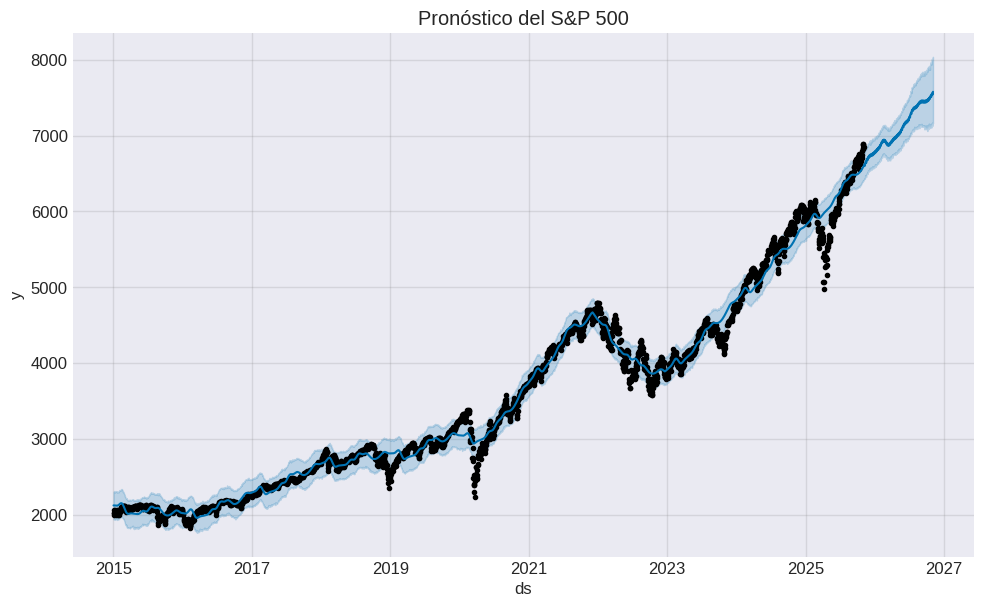


Gráfico de Componentes del Pronóstico del S&P 500:


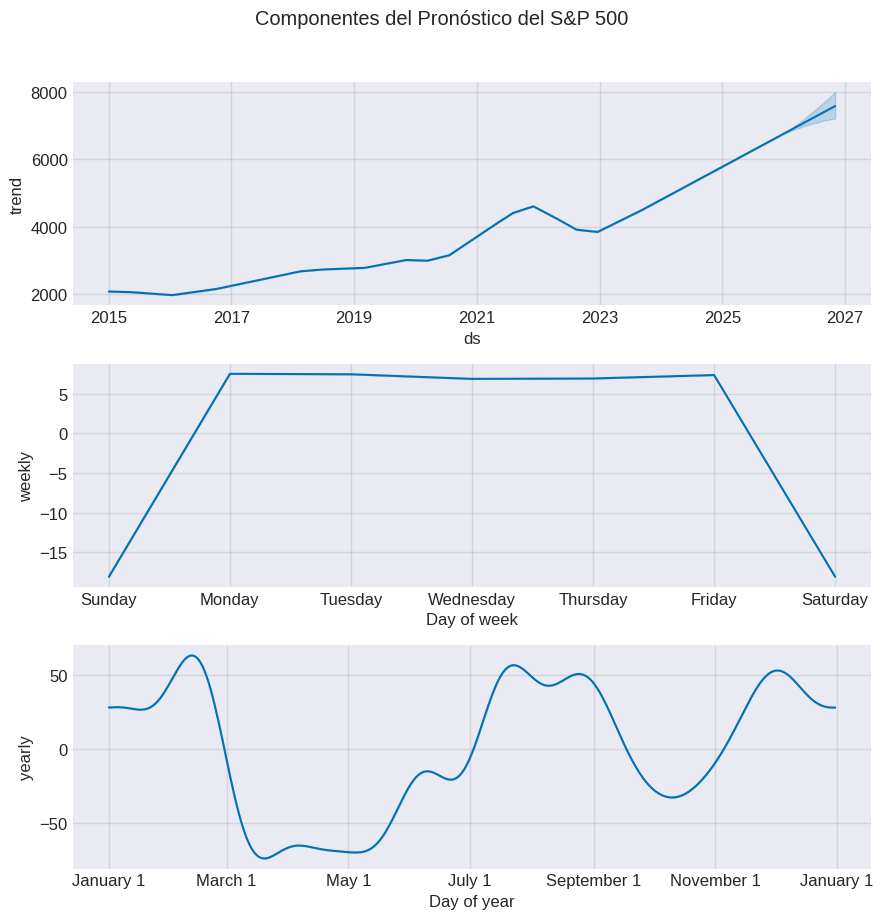

In [ ]:
# Graficar el pronóstico
print("\nGráfico del Pronóstico del S&P 500:")
fig1 = model_sp500.plot(forecast_sp500)
plt.title('Pronóstico del S&P 500')
plt.show()

# Graficar los componentes del pronóstico
print("\nGráfico de Componentes del Pronóstico del S&P 500:")
fig2 = model_sp500.plot_components(forecast_sp500)
plt.suptitle('Componentes del Pronóstico del S&P 500', y=1.02) # Título global para el conjunto de subplots
plt.tight_layout() # Ajusta el layout para evitar superposiciones
plt.show()

Interpretacion de los componentes del gráfico principal.

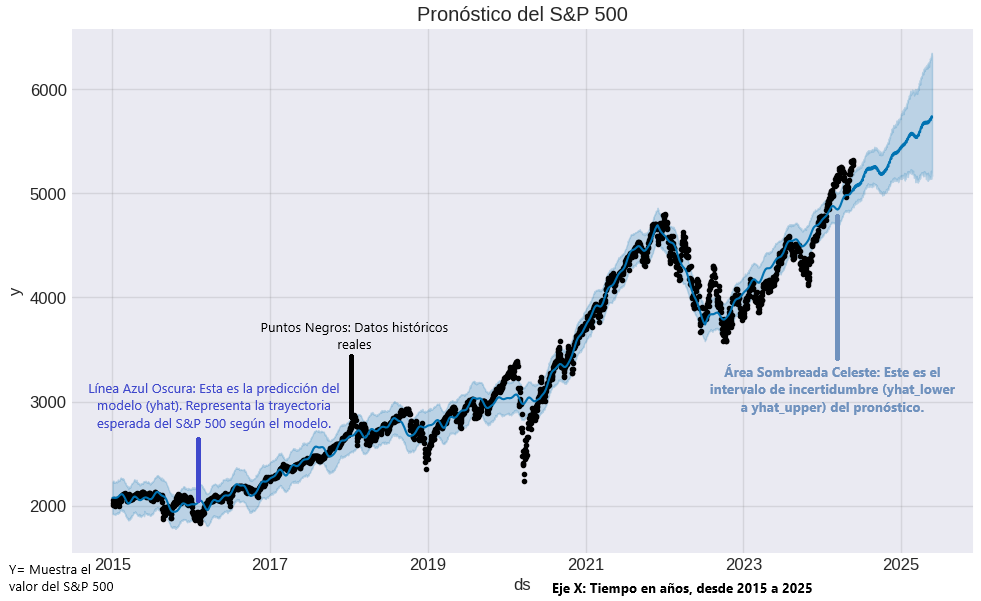

#Ejemplo 2:
Pronóstico del Precio de Bitcoin (con Feriados/Eventos Especiales)
* Objetivo: Predecir el precio de Bitcoin, considerando que ciertas fechas podrían tener un impacto.

In [ ]:
#Obtenemos los Datos del historial de precios de 'BTC-USD'
data_btc = yf.download('BTC-USD', start='2020-01-01', end='2024-05-27')
df_btc = data_btc.reset_index()[['Date', 'Close']]
#Renombrado de Columnas
df_btc.columns = ['ds', 'y']
#Conversión a Datetime
df_btc['ds'] = pd.to_datetime(df_btc['ds'])
print("\nDataFrame para Prophet (Bitcoin):")
print(df_btc.head())

[*********************100%***********************]  1 of 1 completed


DataFrame para Prophet (Bitcoin):
          ds            y
0 2020-01-01  7200.174316
1 2020-01-02  6985.470215
2 2020-01-03  7344.884277
3 2020-01-04  7410.656738
4 2020-01-05  7411.317383


Definir Feriados/Eventos Especiales:

Podemos crear un DataFrame con fechas de eventos y sus nombres.
Prophet puede manejar eventos que se repiten cada año o eventos únicos.

Vamos a ver un ejemplo:

* Definir algunos "eventos especiales" o feriados (ej: un halving de Bitcoin, grandes caídas/subidas).

El halving reduce la oferta de nuevos bitcoins que ingresan al mercado, lo que podría conducir potencialmente a una apreciación del precio si la demanda se mantiene constante o aumenta.

In [ ]:
# Simulamos el halving de Bitcoin en 2020 y 2024
# Define cada evento de halving como un diccionario dentro de una lista.
halvings = pd.DataFrame([
    {'holiday': 'halving', # 'holiday': Nombre del evento (para Prophet).
     'ds': '2020-05-11',    # 'ds': Fecha del evento.
     'lower_window': 0, # Indican cuántos días antes (lower)
     'upper_window': 1}, # Cuantos dias después del evento Prophet debe considerar su impacto
    {'holiday': 'halving', 'ds': '2024-04-19', 'lower_window': 0, 'upper_window': 1},

])
halvings['ds'] = pd.to_datetime(halvings['ds'])
print("\nEventos especiales para Bitcoin:")
print(halvings)


Eventos especiales para Bitcoin:
   holiday         ds  lower_window  upper_window
0  halving 2020-05-11             0             1
1  halving 2024-04-19             0             1


Inicializar y Entrenar el Modelo (con feriados):

Pasar el DataFrame de feriados al parámetro holidays.

In [ ]:
model_btc = Prophet(daily_seasonality=False,
                    weekly_seasonality=True,
                    yearly_seasonality=True,
                    holidays= halvings, # ¡Aquí pasamos los eventos!
                    changepoint_prior_scale=0.08 # Un poco más flexible la tendencia
                   )
model_btc.fit(df_btc)
print("\nModelo Prophet para Bitcoin entrenado (con eventos).")


Modelo Prophet para Bitcoin entrenado (con eventos).


Crear DataFrame de Futuro y Pronosticar:

In [ ]:
future_btc = model_btc.make_future_dataframe(periods=180, freq='D') # 6 meses
forecast_btc = model_btc.predict(future_btc)
print("\nPronóstico de Bitcoin (primeros y últimos valores):")
print(forecast_btc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()) # primeros 5 puntos del pronóstico
print(forecast_btc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()) # últimos 5 puntos del pronóstico


Pronóstico de Bitcoin (primeros y últimos valores):
          ds         yhat   yhat_lower    yhat_upper
0 2020-01-01  8462.191539  4634.791082  12523.489152
1 2020-01-02  8390.232081  4578.426549  12304.190143
2 2020-01-03  8413.038617  4238.283770  12465.184479
3 2020-01-04  8394.472061  4726.088587  12060.958957
4 2020-01-05  8408.727272  4859.739431  12186.750865
             ds          yhat    yhat_lower    yhat_upper
1783 2024-11-18  74331.286147  50085.278189  98264.555026
1784 2024-11-19  74328.857573  50835.839042  98603.241831
1785 2024-11-20  74535.596392  50553.171685  99282.717838
1786 2024-11-21  74506.040283  49611.579297  99567.911484
1787 2024-11-22  74586.482932  51023.704315  98943.865473


Visualizar el Pronóstico y Componentes:


Gráfico del Pronóstico de Bitcoin:


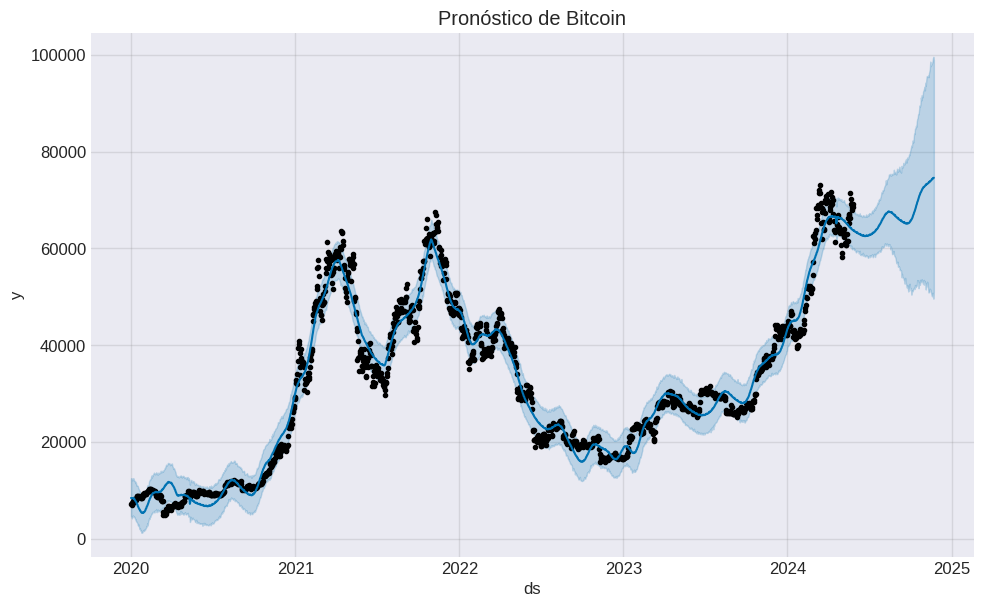


Gráfico de Componentes del Pronóstico de Bitcoin:


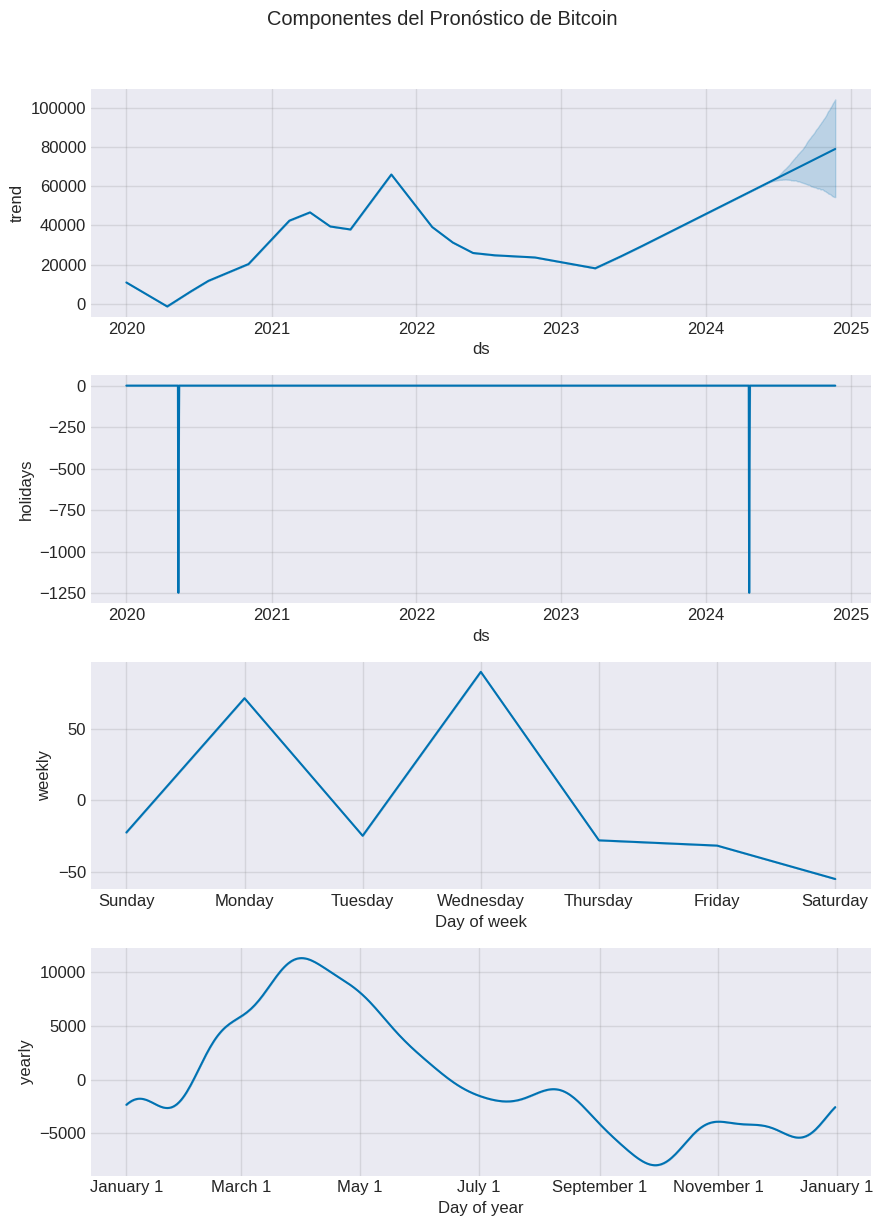

In [ ]:
print("\nGráfico del Pronóstico de Bitcoin:")
fig3 = model_btc.plot(forecast_btc)
plt.title('Pronóstico de Bitcoin')
plt.show()

print("\nGráfico de Componentes del Pronóstico de Bitcoin:")
fig4 = model_btc.plot_components(forecast_btc)
plt.suptitle('Componentes del Pronóstico de Bitcoin', y=1.02)
plt.tight_layout()
plt.show()

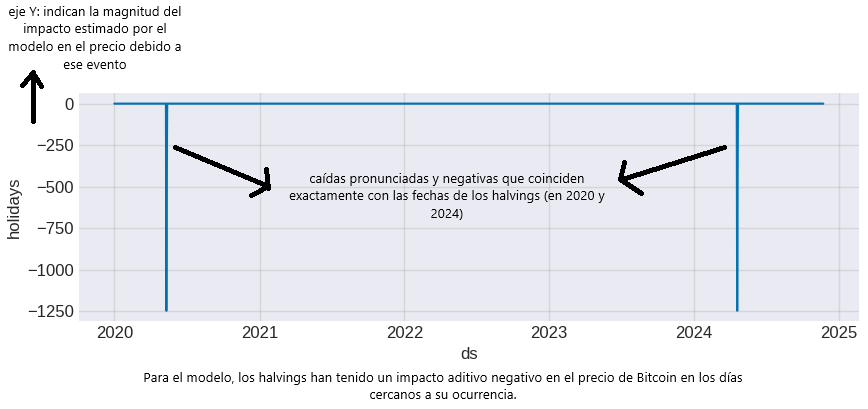